In [1]:
# Daily AgriMet Parameters
# ET : Kimberly-Penman ETr (inches)
# MM: Mean Temperature (degF)
# MN: Minimum Temperature (degF)
# MX: Maximum Temperature (degF)
# PP: Daily precipitation total (in)
# PU: Water year precipitaiton total (in)
# SR: Daily accumulated solar radiation (langleys)
# TA: Mean humidity (%)
# UA: Daily Mean Wind Speed (mph)
# WD: Wind Direction average (deg)

In [ ]:
import AgriMetPy as agmet
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import pandas as pd
from datetime import datetime, timedelta
# OS interaction
import sys
import os

In [24]:
# Dictonary of Column Names - Map AgriMet Names to Standard Names

pa_cw = {
    'MN': 'tn',
    'MX': 'tx',
    'TA': 'rh',
    'UA': 'ff',
    'SR': 'sr',
    'PP': 'rr'
}

# List of AgriMet Parameters

pa_list = ['MN', 'MX', 'TA', 'UA', 'SR', 'PP']

# Parameter Ranges for Quality Control (QC)

pa_qc = pd.DataFrame(index=['Min', 'Max'], columns=pa_list)
pa_qc['MX'] = np.array([-100,150])
pa_qc['MN'] = np.array([-100,150])
pa_qc['TA'] = np.array([0,100])
pa_qc['UA'] = np.array([0,150])
pa_qc['SR'] = np.array([0,10000])
pa_qc['PP'] = np.array([0,50])

pa_qc.rename(columns=pa_cw, inplace=True)

# Parameter Unit Conversion

pa_uc = pd.DataFrame(index=['Add', 'Mult'], columns=pa_list)
pa_uc['MX'] = np.array([-32,5/9])
pa_uc['MN'] = np.array([-32,5/9])
pa_uc['TA'] = np.array([0,0])
pa_uc['UA'] = np.array([0,0.44704])
pa_uc['SR'] = np.array([0,0.484583])
pa_uc['PP'] = np.array([0,25.4])

pa_uc.rename(columns=pa_cw, inplace=True)

In [3]:
def agrimet_to_df(start, end, st_list, pa_subset):
    api_init = agmet.AgriMet(token = 'test')    
    api_rtrn = api_init.timeseries(start = start, end = end, st = st_list, pa = pa_subset)
    data_raw = api_rtrn['SITE']['DATA']
    data_keys = list(data_raw[0].keys())
    data_keys = data_keys[1:len(data_keys)]

    # Parse Data to Pandas Dataframe
    time_vec = [datetime.strptime(data_raw[cd]['DATE'], '%Y/%m/%d') for cd in range(len(data_raw))]
    data_df = pd.DataFrame(index=time_vec, columns=data_keys)
    for iter in range(0,len(data_raw)):
        for key in data_keys:
            data_df[key][iter] = float(data_raw[iter][key])
    return(data_df)

In [5]:
start = '19970401'
end = '20180930'
st_list = ['BFAM','BFTM','BOMT','GFMT','GLGM','HRLM','MATM','MWSM','TRFM']

In [47]:
for st_sel in st_list:
    # Check Parameter List Count
    pa_ct = len(pa_list)

    # If Parameter Count Greater Than 5, Split API Call into 2
    if pa_ct > 5:
        # Parameter Set 1 [Params 1-4]
        pa_subset = ','.join(pa_list[0:4])
        # API Call
        df1 = agrimet_to_df(start, end, st_list, pa_subset)
        # Parameter Set 2 [Params 5-6]
        pa_subset2 = ','.join(pa_list[4:6])
        # API Call
        df2 = agrimet_to_df(start, end, st_list, pa_subset2)
        # Merge Data Frames
        df_out = pd.merge(df1,df2,left_index=True, right_index=True)
    else:
        pa_subset = ','.join(pa_list)
        df_out = agrimet_to_df(start, end, st_list, pa_subset)
        
    # Rename Data Columns
    df_out.rename(columns=pa_cw, inplace=True)
    df_out.index.name='Date'

    # QC Check and Unit Conversion
    for col in df_out:
        df_out[col + '_QC'] = np.where((df_out[col]>= pa_qc[col][0]) & (df_out[col]<= pa_qc[col][1]), 1, 0)
        df_out[col] = (df_out[col] + pa_uc[col][0]) * pa_uc[col][1]  

    # Save Data to File 
    file_out = st_sel + '.dat'
    df_out.to_csv(file_out)

In [42]:
df_filtered = df_out.query('tn_QC==1')

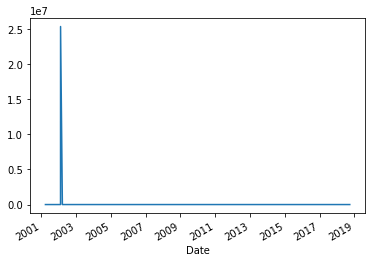

In [46]:
df_filtered['rr'].plot()